Using font: C:\Windows\Fonts\timesbd.ttf


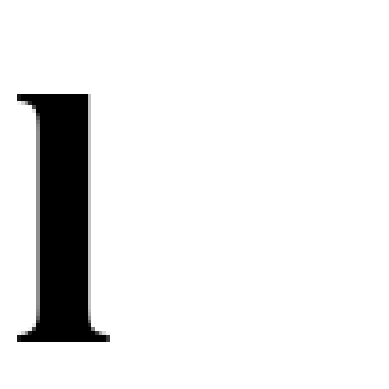

多边形无效！
多边形坐标： [[ 3 23]
 [25 89]
 [24 89]
 ...
 [ 5 23]
 [ 4 23]
 [ 3 23]]
3D模型生成失败！


In [40]:
import numpy as np
import trimesh
from PIL import Image, ImageDraw, ImageFont
import matplotlib.font_manager as fm
from shapely.geometry import Polygon
# 获取字体路径
def get_font_path(text, font_path, size=100):
    # 使用Pillow渲染文本
    font = ImageFont.truetype(font_path, size)
    image = Image.new('L', (size * len(text), size), 255)  # L模式为灰度图
    draw = ImageDraw.Draw(image)
    draw.text((0, 0), text, font=font, fill=0)  # 渲染文本

    # 转换为二值图像
    image = np.array(image)
    plt.imshow(image, cmap='gray')
    plt.axis('off')  # 不显示坐标轴
    plt.show()
    # 提取路径
    contours = []
    for i in range(image.shape[0] - 1):
        for j in range(image.shape[1] - 1):
            if image[i, j] == 0:  # 找到文字区域
                contours.append((j, i))
    
    contours = np.array(contours)
    
    return contours

def create_2d_mesh_from_path(paths):
    # 将路径转换为shapely的Polygon对象，确保路径是闭合的
    paths = np.array(paths)
    
    # 确保路径闭合
    if not np.array_equal(paths[0], paths[-1]):
        paths = np.vstack([paths, paths[0]])  # 将第一个点添加到最后，闭合路径

    paths = paths[::-1]
    # 创建shapely的Polygon对象
    polygon = Polygon(paths)
    
    # 检查是否为有效的多边形
    if not polygon.is_valid:
        print("多边形无效！")
        print("多边形坐标：", paths)
        # 打印多边形的修复建议
        return None
    
    # 提取多边形的外边界（如果是一个简单的多边形）
    exterior_coords = np.array(polygon.exterior.coords)
    
    # 生成三角化的面
    # 使用shapely的多边形进行三角化
    from shapely.geometry import MultiPolygon
    from shapely.ops import triangulate
    
    triangles = triangulate(polygon)
    
    # 将三角形转换为 trimesh 面
    faces = []
    vertices = []

    for tri in triangles:
        # 将每个三角形的顶点提取并保存
        exterior_coords = np.array(tri.exterior.coords)
        vertex_start = len(vertices)
        
        for pt in exterior_coords:
            vertices.append(pt)
        
        # 对应的面
        faces.append([vertex_start, vertex_start + 1, vertex_start + 2])

    # 转换为numpy数组
    vertices = np.array(vertices)
    faces = np.array(faces)

    # 创建Trimesh对象
    mesh = trimesh.Trimesh(vertices=vertices, faces=faces)

    # 检查网格是否为空
    if mesh.is_empty:
        print("生成的2D网格为空！")
        return None
    
    return mesh

# 主函数
def main():
    text = "l"
    
    # 获取所有安装的字体路径
    font_paths = fm.findSystemFonts()
    
    # 选择一个字体路径 (可以选择一个合适的字体)
    font_path = font_paths[0]  # 使用第一个字体路径，或者选择一个你需要的字体
    print("Using font:", font_path)
    
    # 获取2D路径
    contours = get_font_path(text, font_path)
    
    if contours is None or len(contours) == 0:
        print("没有路径生成，请检查字体和渲染设置。")
    else:
        # 生成3D模型
        mesh = create_2d_mesh_from_path(contours)
        
        if mesh:
            # 保存为 OBJ 文件
            mesh.export("output.obj")
            print("OBJ file saved as 'output.obj'")
        else:
            print("3D模型生成失败！")

if __name__ == "__main__":
    main()